In [1]:
import PKoopmanDL as pkdl
import numpy as np
import matplotlib.pyplot as plt
import torch

# read the config file
config_file = "kdv.json"
solver = pkdl.ParamKoopmanDLSolverWrapper(config_file)

# set up the grid
Nx = 128
x_max = torch.pi
x_min = -torch.pi
x_step = (x_max - x_min) / (Nx - 1)
x_grid = torch.linspace(x_min, x_max, Nx).unsqueeze(0)

# initial condition: eta(x) = b1 exp(-(x-pi/2)) + b2 (-sin(x/2)^2) + b3 exp(-(x+pi/2)^2)
def sample_func(row_size, col_size):
  assert (col_size == Nx)
  x = x_grid.expand(row_size, Nx)
  # torch.manual_seed(0)
  uniform = torch.tensor([1.0, 1.0, 1.0])
  b = torch.distributions.Dirichlet(uniform).sample((row_size,))
  b1 = b[:, 0].view(-1, 1)
  b2 = b[:, 1].view(-1, 1)
  b3 = b[:, 2].view(-1, 1)
  eta = b1 * torch.exp(-(x - torch.pi / 2)**2) - b2 * torch.sin(
      x / 2)**2 + b3 * torch.exp(-(x + torch.pi / 2)**2)
  return eta

def mass_func(x):
  mass = torch.sum(x, dim=1, keepdim=True) * x_step
  return mass

def momentum_func(x):
  momentum = torch.sum(x **2, dim=1, keepdim=True) * x_step
  return momentum

def mass_momentum_func(x):
  mass = mass_func(x)
  momentum = momentum_func(x)
  return torch.cat((mass, momentum), dim=1)

observable_func = pkdl.ObservableFunction(mass_momentum_func, 2)


# set up the solver
solver.load_dataset_setup("data/kdv_dataset.pt", observable_func, sample_func)
K = solver.solve()
koopman_dynamics = pkdl.KoopmanODEDynamics(solver.dynamics, K, solver.dictionary, solver.dynamics.dim, solver.dynamics.param_dim)

2024-11-30 15:56:13,832 PKoopmanDL: [INFO] [ParamKoopmanDLSolver] Solving...
Training: 100%|██████████| 1000/1000 [09:13<00:00,  1.81it/s, train_loss=9.59e-04, val_loss=9.44e-04]


## Solve the Tracking Problem

In [2]:
traj_len = solver.traj_len * 2
t_step = solver.t_step
time_horizon = 10
lambda_param = 0.005

state0 = torch.zeros(solver.dynamics.dim) + 0.2
mass_ref = torch.zeros(traj_len, 1)
momentum_ref = torch.zeros(traj_len, 1)



for i in range(traj_len):
  if i > traj_len / 2:
    mass_ref[i, :] = 3.16
    momentum_ref[i, :] = 1.58
  else:
    mass_ref[i, :] = 1.90
    momentum_ref[i, :] = 0.57


mass_solver = pkdl.KoopmanMPCSolver(solver.dynamics, K, solver.dictionary, mass_ref, time_horizon, 0, lambda_param)
mass_controls = mass_solver.solve(state0, -1, 1)

momentum_solver = pkdl.KoopmanMPCSolver(solver.dynamics, K, solver.dictionary, momentum_ref, time_horizon, 1, lambda_param)
momentum_controls= momentum_solver.solve(state0, -1, 1)


2024-11-30 16:05:28,141 PKoopmanDL: [INFO] [KoopmanMPCSolver] Solving the optimal control problem...
Solving:   6%|▌         | 57/990 [05:04<1:40:07,  6.44s/it, loss=2.72e-02]/home/yxqian/anaconda3/envs/koopman/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Solving: 100%|██████████| 990/990 [1:18:38<00:00,  4.77s/it, loss=4.32e-05]
2024-11-30 17:24:06,622 PKoopmanDL: [INFO] [KoopmanMPCSolver] Solving the optimal control problem...
Solving: 100%|██████████| 990/990 [1:18:04<00:00,  4.73s/it, loss=1.03e-04]


In [3]:

t_grid = np.arange(0, traj_len)
mass_traj = koopman_dynamics.traj(state0.unsqueeze(0), mass_controls.to(torch.float32), traj_len)
momentum_traj = koopman_dynamics.traj(state0.unsqueeze(0), momentum_controls.to(torch.float32), traj_len)


Generating trajectory: 100%|██████████| 999/999 [55:17<00:00,  3.32s/it]


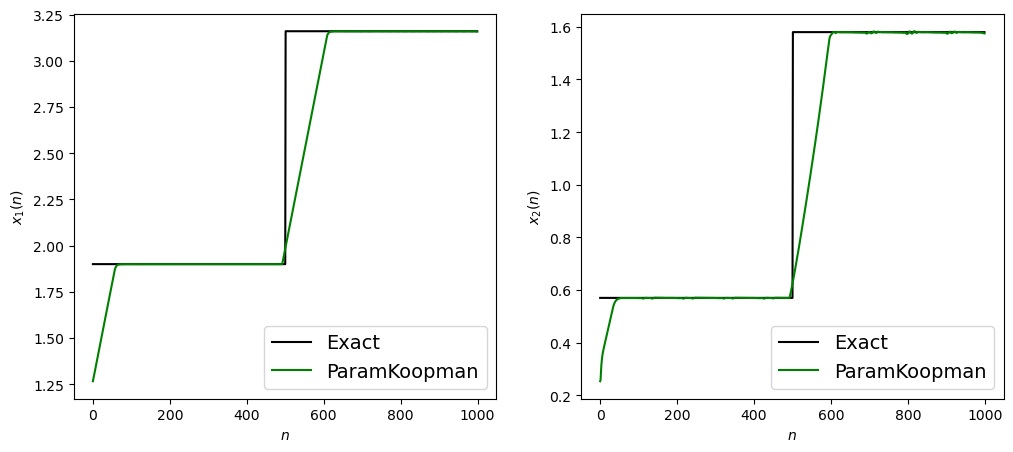

In [11]:

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12,5))  
ax1.plot(t_grid, mass_ref.detach().numpy()[:,0], 'k-', label='Exact', markevery=2)
ax1.plot(t_grid, mass_traj.detach().numpy()[0,:,0], 'g-', label='ParamKoopman', markevery=2)

ax2.plot(t_grid, momentum_ref.detach().numpy()[:,0], 'k-', label='Exact', markevery=2)
ax2.plot(t_grid, momentum_traj.detach().numpy()[0,:,1], 'g-', label='ParamKoopman', markevery=2)

ax1.set_xlabel(r"$n$")
ax1.set_ylabel(r"$x_{1}(n)$")
ax1.legend(loc='best',prop={'size':14})

ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"$x_{2}(n)$")
ax2.legend(loc='best',prop={'size':14})